In [3]:
#from netCDF4 import Dataset
import geopy.distance
import xarray as xr
#import pandas
import matplotlib as mpl
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
dir_data='F:/data/sat_data/ccmp/v02.0/'

def get_ccmp_filename_daily(lyr,idyjl):
    dir_data='F:/data/sat_data/ccmp/v02.0/'
    d = dt.date(lyr,1,1) + dt.timedelta(idyjl - 1)
    syr, smon, sdym =str(d.year).zfill(4), str(d.month).zfill(2), str(d.day).zfill(2)
    filename = dir_data + 'Y' + syr + '/M' + smon + '/CCMP_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    if lyr>=2018:
        filename = dir_data + 'Y' + syr + '/M' + smon + '/CCMP_RT_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    return filename


def cal_dist(ds):
    lons = ds.lon.values
    lats = ds.lat.values
    ilen_lats = len(lats)
    dx=[0]*len(lats)
    dy=[0]*len(lats)
    dx_grid = np.empty([len(lats),len(lons)])    
    dy_grid = np.empty([len(lats),len(lons)])    
    for j in range(0,len(lats)):
        i=10 #just a random lon
        coords_1 = (lats[j], lons[i-1])  #cpr sample location
        coords_2 = (lats[j], lons[i])  #eddy location
        arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m   
        for i in range(1,len(lons)-1):
            dx[j]=arclen_temp
    for j in range(1,len(lats)):
        i=10 #just a random lon
        coords_1 = (lats[j], lons[i])  #cpr sample location
        coords_2 = (lats[j-1], lons[i])  #eddy location
        arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m       
        dy[j]=arclen_temp
    j=0
    i=10 #just a random lon
    coords_1 = (lats[j], lons[i])  #cpr sample location
    coords_2 = (lats[j+1], lons[i])  #eddy location
    arclen_temp = geopy.distance.geodesic(coords_1, coords_2).m       
    dy[j]=arclen_temp
    for i in range(0,len(lons)):
        for j in range(0,len(lats)):
            dx_grid[j,i]=dx[j]
            dy_grid[j,i]=dy[j]
    datax = xr.DataArray(dx_grid, coords={'lat': ds.lat,'lon':ds.lon}, dims=('lat', 'lon'))
    datay = xr.DataArray(dy_grid, coords={'lat': ds.lat,'lon':ds.lon}, dims=('lat', 'lon'))
    ds['dx_grid']=datax
    ds['dy_grid']=datay
    return ds


def wrf_vort( U, V, dx,dy ):
    """Calculate the relative vorticity given the U and V vector components in m/s
    and the grid spacing dx in meters.
    U and V must be the same shape.
    ---------------------
    U (numpy.ndarray): ndarray of U vector values in m/s
    V (numpy.ndarray): ndarray of V vector values in m/s
    dx (float or int): float or integer of U and V grispacing in meters
    ---------------------
    returns:
        numpy.ndarray of vorticity values s^-1 same shape as U and V
    """
#    assert U.shape == V.shape, 'Arrays are different shapes. They must be the same shape.'
    
    du = np.gradient( U )
    dv = np.gradient( V )
    return ( dv[-1]/dx - du[-2]/dy )

In [4]:
lyr=2000
filename = get_ccmp_filename_daily(2000,1)
ds = xr.open_dataset(filename,drop_variables='nobs')
ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi
ds = ds.rename({'longitude':'lon','latitude':'lat'})
print(ds)
ds.close()
ds2= cal_dist(ds)

<xarray.Dataset>
Dimensions:  (lat: 628, lon: 1440, time: 4)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -78.375 -78.125 -77.875 ... 77.875 78.125 78.375
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T18:00:00
Data variables:
    uwnd     (time, lat, lon) float32 2.101699 2.131792 ... -9.585934 -9.500353
    vwnd     (time, lat, lon) float32 -2.6582468 -2.64885 ... 10.275465
    spd      (time, lat, lon) float32 3.3887188 3.4001389 ... 13.994352
    dir      (time, lat, lon) float32 -51.668915 -51.17292 ... 132.75545
Attributes:
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure:             grid
    title:                      RSS CCMP V2.0 derived surface winds (Level 3.0)
    history:                    20160212T034001ZZ - netCDF generated from ori...
    description:                RSS VAM 6-hour analyses starting 

In [5]:
ds2= cal_dist(ds)

In [13]:
dvort = []
init_vort = 0
for i in range(0,4):
    dvort = wrf_vort( ds.uwnd[0,:,:], ds.vwnd[0,:,:], ds.dx_grid,ds.dy_grid)
    if init_vort==0:
        ds_vort = dvort
        init_vort = 1
    else:
        ds_vort = xr.concat([ds_vort,dvort],dim = 'time')


In [15]:
ds2['rel_vorticity']=ds_vort

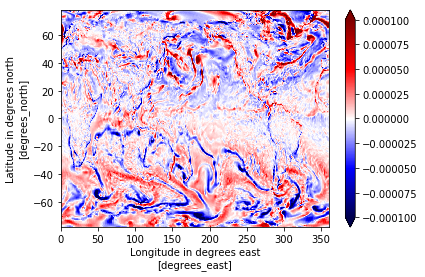

In [10]:
dvort.plot(vmin=-.0001,vmax=.0001,cmap='seismic')

In [11]:
ds2['rel_vorticity']=dvort

In [12]:
ds2

<xarray.Dataset>
Dimensions:        (lat: 628, lon: 1440, time: 4)
Coordinates:
  * lon            (lon) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * lat            (lat) float32 -78.375 -78.125 -77.875 ... 78.125 78.375
  * time           (time) datetime64[ns] 2000-01-01 ... 2000-01-01T18:00:00
Data variables:
    uwnd           (time, lat, lon) float32 2.101699 2.131792 ... -9.500353
    vwnd           (time, lat, lon) float32 -2.6582468 -2.64885 ... 10.275465
    spd            (time, lat, lon) float32 3.3887188 3.4001389 ... 13.994352
    dir            (time, lat, lon) float32 -51.668915 -51.17292 ... 132.75545
    dx_grid        (lat, lon) float64 5.626e+03 5.626e+03 ... 5.626e+03
    dy_grid        (lat, lon) float64 2.791e+04 2.791e+04 ... 2.791e+04
    rel_vorticity  (lat, lon) float64 -4.132e-06 -4.253e-06 ... -1.964e-05
Attributes:
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure: